<h1 align="center"><font size="5"><b>癌症风险预测 - 分类</b></font></h1>
<h1 align="center"><font size="5"><b>程序员：叶博文</b></font></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Importing Dataset

In [3]:
df = pd.read_csv('dataset/China Cancer Patients Dataset.csv')
df.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PatientID             10000 non-null  object 
 1   Gender                10000 non-null  object 
 2   Age                   10000 non-null  int64  
 3   Province              10000 non-null  object 
 4   Ethnicity             10000 non-null  object 
 5   TumorType             10000 non-null  object 
 6   CancerStage           10000 non-null  object 
 7   DiagnosisDate         10000 non-null  object 
 8   TumorSize             10000 non-null  float64
 9   Metastasis            10000 non-null  object 
 10  TreatmentType         10000 non-null  object 
 11  SurgeryDate           4327 non-null   object 
 12  ChemotherapySessions  10000 non-null  int64  
 13  RadiationSessions     10000 non-null  int64  
 14  SurvivalStatus        10000 non-null  object 
 15  FollowUpMonths      

Note: The dataset contains 10,000 rows and 19 columns, with the target variable being 'SurvivalStatus', which indicates whether the patient survived or not. The dataset includes various features, such as PatientID, Gender, Age, Province, etc. The 'SurvivalStatus' column is the target variable, which is binary (0 for not survived, 1 for survived).

There are some missing values in the dataset, particularly in the SurgeryDate, AlcoholUse, GeneticMutation, and Comorbidities columns. The 'SurgeryDate' column has 5,673 missing values, while 'AlcoholUse' has 5,921 missing values. The 'GeneticMutation' column has 7,200 missing values, and the 'Comorbidities' column has 3,715 missing values.

We will need to handle these missing values appropriately before proceeding with the analysis and modeling. Additionally, we will need to encode categorical variables and scale numerical features as part of the preprocessing steps.

- For SurgeryDate, we can fill the missing values with the mean date of the differences between the surgery date and the diagnosis date.
- For AlcoholUse, we will assume the missing values as 'Never'.
- For GeneticMutation, we will assume the missing values as 'No Mutation'.
- For Comorbidities, we will assume the missing values as 'No Comorbidities'.

In [5]:
df.describe(include='all')

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
count,10000,10000,10000.000000,10000,10000,10000,10000,10000,10000.000000,10000,10000,4327,10000.0000,10000.000000,10000,10000.000000,10000,4079,2800,6285
unique,10000,3,NaN,13,6,6,4,4383,NaN,2,5,2915,NaN,NaN,2,NaN,3,2,3,9
top,CHN-09984,Female,NaN,Guangdong,Han,Lung,II,2010-11-19,NaN,No,Chemotherapy,2019-01-31,NaN,NaN,Alive,NaN,Never,Occasional,EGFR,Hypertension
freq,1,3371,NaN,1841,9110,2561,2971,8,NaN,7301,2072,5,NaN,NaN,7790,NaN,5011,3127,1389,1514
mean,NaN,NaN,51.600200,NaN,NaN,NaN,NaN,NaN,6.339040,NaN,NaN,NaN,3.9990,3.046400,NaN,30.432800,NaN,NaN,NaN,NaN
std,NaN,NaN,19.705608,NaN,NaN,NaN,NaN,NaN,2.234999,NaN,NaN,NaN,6.2036,7.301505,NaN,17.162545,NaN,NaN,NaN,NaN
min,NaN,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,0.0000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,4.800000,NaN,NaN,NaN,0.0000,0.000000,NaN,16.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,51.000000,NaN,NaN,NaN,NaN,NaN,6.400000,NaN,NaN,NaN,0.0000,0.000000,NaN,31.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,69.000000,NaN,NaN,NaN,NaN,NaN,7.900000,NaN,NaN,NaN,8.0000,0.000000,NaN,45.000000,NaN,NaN,NaN,NaN


# 2. Data Preprocessing

## a. Handling Missing Values

In [6]:
# SurgeryDate: Fill missing values with the mean date of the differences between SurgeryDate and DiagnosisDate
df['SurgeryDate'] = pd.to_datetime(df['SurgeryDate'], errors='coerce')
df['DiagnosisDate'] = pd.to_datetime(df['DiagnosisDate'], errors='coerce')

# Calculate the mean difference in days between SurgeryDate and DiagnosisDate
mean_diff = (df['SurgeryDate'] - df['DiagnosisDate']).dropna().dt.days.mean()
mean_diff

np.float64(104.75132886526461)

In [7]:
# Fill missing SurgeryDate with DiagnosisDate + mean_diff
df_clean = df.copy()
df_clean['SurgeryDate'] = df_clean['SurgeryDate'].fillna(df_clean['DiagnosisDate'] + pd.Timedelta(days=mean_diff))

df_clean['SurgeryDate'] = df_clean['SurgeryDate'].dt.strftime('%Y-%m-%d')
df_clean.head()


,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,2012-05-21,4,0,Alive,42,Never,NaN,NaN,NaN


In [8]:
# AlcoholUse: Fill missing values with 'Never'
df_clean['AlcoholUse'] = df_clean['AlcoholUse'].fillna('Never')

# GeneticMutation: Fill missing values with 'No Mutation'
df_clean['GeneticMutation'] = df_clean['GeneticMutation'].fillna('No Mutation')

# Comorbidities: Fill missing values with 'No Comorbidities'
df_clean['Comorbidities'] = df_clean['Comorbidities'].fillna('No Comorbidities')

df_clean

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,Never,No Mutation,No Comorbidities
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,Never,No Mutation,No Comorbidities
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,No Comorbidities
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,2012-05-21,4,0,Alive,42,Never,Never,No Mutation,No Comorbidities
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CHN-09996,Female,21,Shandong,Han,Liver,IV,2018-07-11,8.5,Yes,Targeted Therapy,2018-11-14,12,0,Alive,57,Never,Occasional,KRAS,Hypertension
9996,CHN-09997,Female,35,Shanghai,Han,Cervical,II,2016-03-31,6.5,No,Targeted Therapy,2016-09-03,20,0,Alive,36,Never,Never,No Mutation,Hepatitis B
9997,CHN-09998,Female,58,Shandong,Han,Cervical,III,2019-09-03,8.0,Yes,Immunotherapy,2019-11-29,0,0,Alive,35,Former,Occasional,No Mutation,"Hepatitis B, Hypertension"
9998,CHN-09999,Male,26,Hebei,Han,Lung,I,2014-03-16,6.2,No,Chemotherapy,2014-06-28,2,0,Alive,25,Current,Occasional,KRAS,No Comorbidities


In [9]:
df_clean.isnull().sum()

PatientID               0
Gender                  0
Age                     0
Province                0
Ethnicity               0
TumorType               0
CancerStage             0
DiagnosisDate           0
TumorSize               0
Metastasis              0
TreatmentType           0
SurgeryDate             0
ChemotherapySessions    0
RadiationSessions       0
SurvivalStatus          0
FollowUpMonths          0
SmokingStatus           0
AlcoholUse              0
GeneticMutation         0
Comorbidities           0
dtype: int64

There's no missing values in the dataset after preprocessing. The 'SurgeryDate' column has been filled with the mean date of the differences between the surgery date and the diagnosis date, while the other columns have been filled with appropriate default values.

## b. Checking for duplicates

In [10]:
df_clean.duplicated().sum()

np.int64(0)

## c. Checking for outliers in numerical features

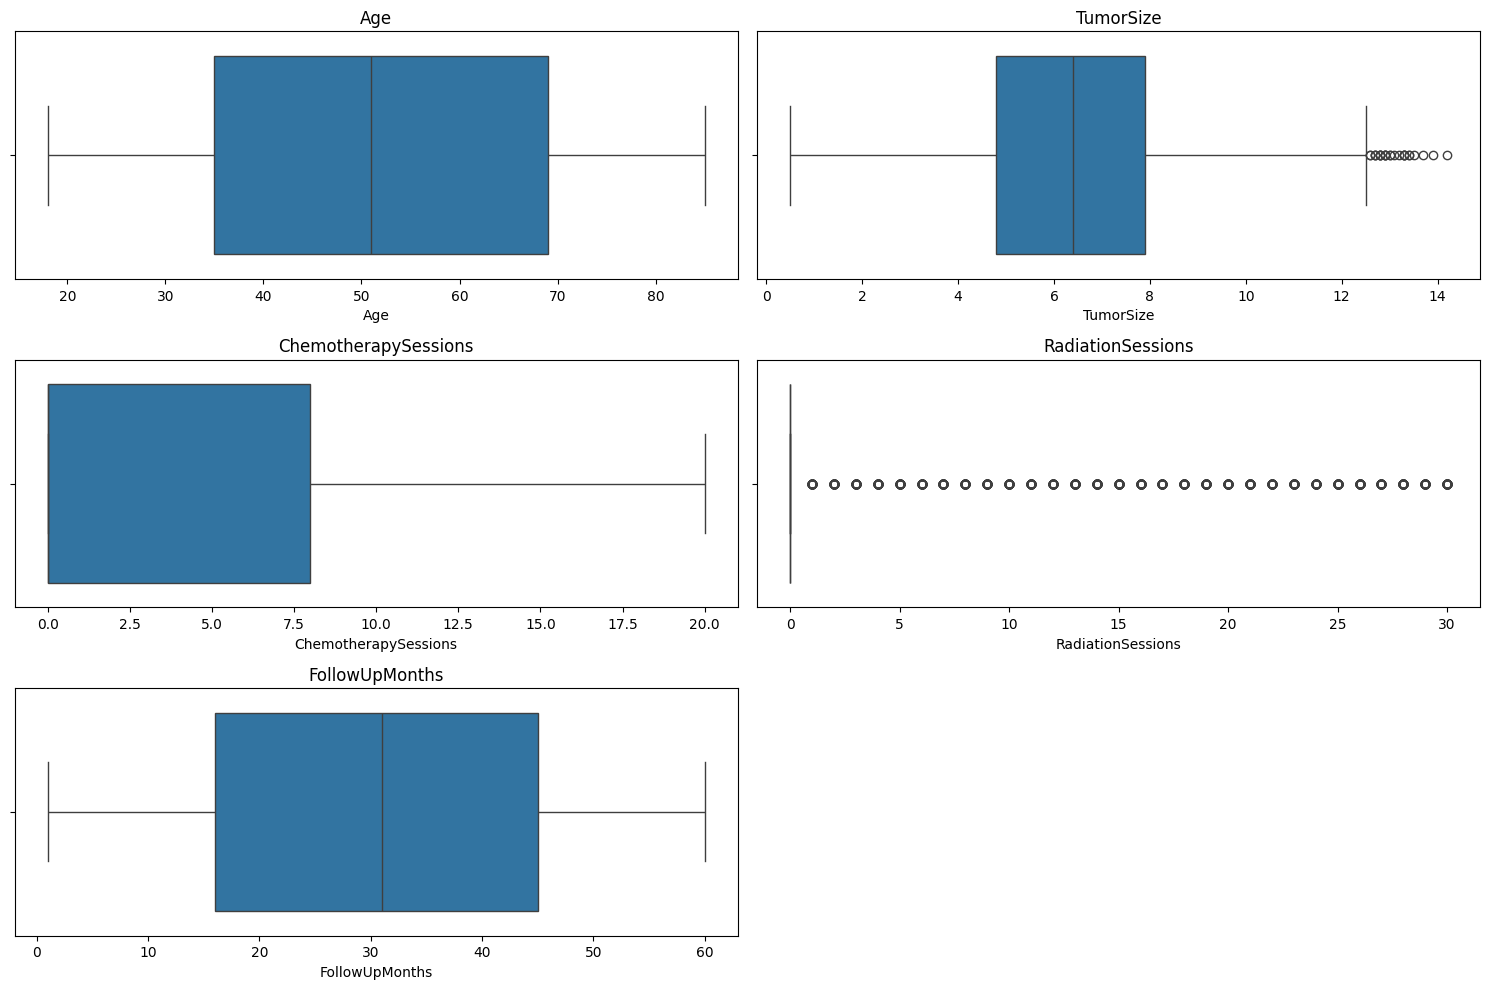

In [11]:
# Checking outlier with boxplot for numerical features
numerical_features = df_clean.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=df_clean[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

Note: There are some outliers in the numerical features, particularly in 'TumorSize' and 'ChemotherapySessions'. However, we will not remove them at this stage, as they may represent valid data points that could be important for the analysis.

# 3. EDA

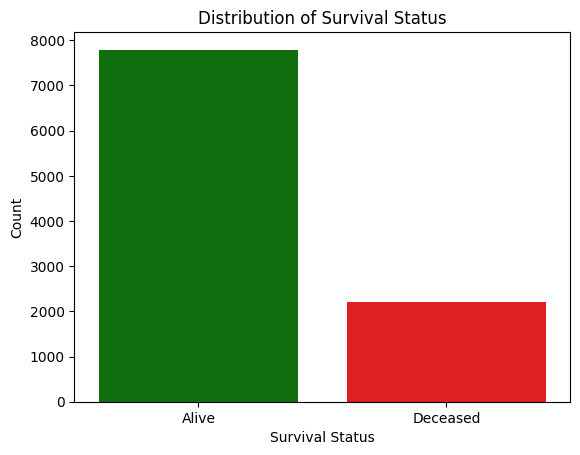

In [12]:
# Visualize the distribution of the target variable 'SurvivalStatus'
color_palette = ['green', 'red']
sns.countplot(x='SurvivalStatus', data=df_clean, palette=color_palette)
plt.title('Distribution of Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.show()

In [13]:
# Calculate the percentage of each class in the target variable
survival_counts = df_clean['SurvivalStatus'].value_counts(normalize=True) * 100
survival_counts

SurvivalStatus
Alive       77.9
Deceased    22.1
Name: proportion, dtype: float64

Note: The dataset is imbalanced, with 77.9% of patients is survived and 22.1% of patients is not survived. This imbalance may affect the performance of the classification models, so I decided to do Over Sampling Technique later on)

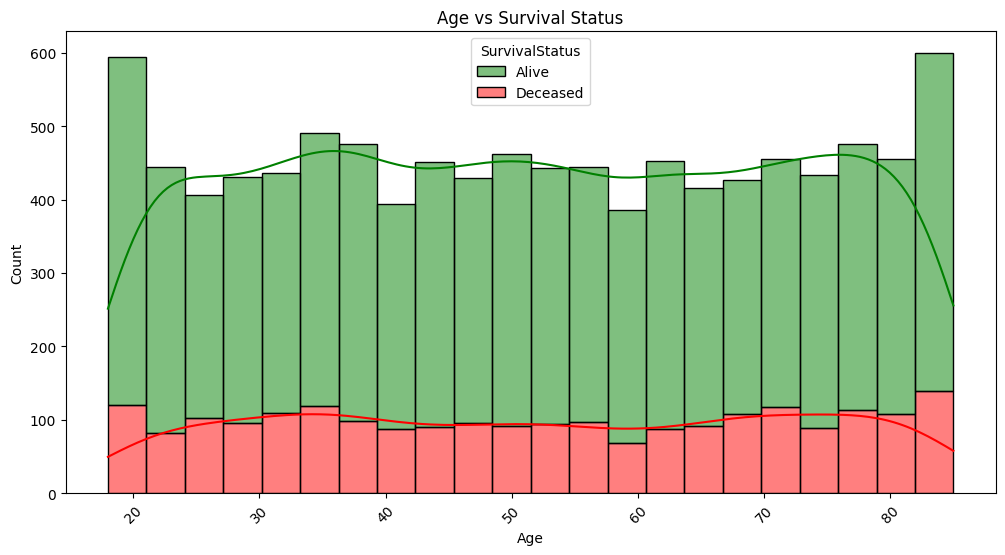

In [14]:
# Visualize the distribution of age vs survival status
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='Age', hue='SurvivalStatus', multiple='stack', kde=True, palette=color_palette)
plt.title('Age vs Survival Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note:

<Figure size 800x600 with 0 Axes>

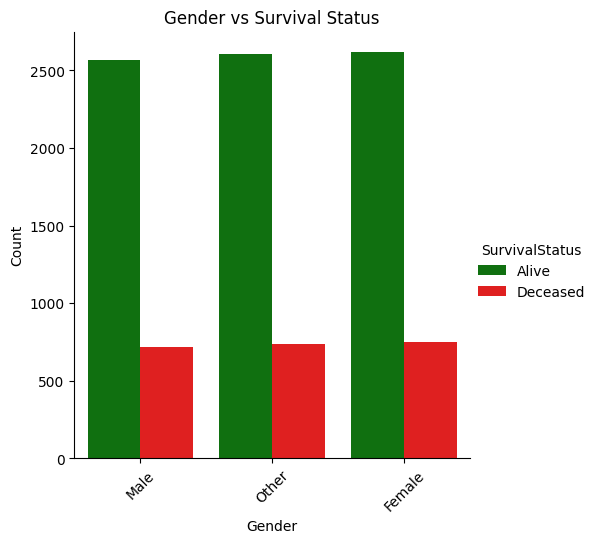

In [15]:
# Visualize the distribution of gender vs survival status
plt.figure(figsize=(8, 6))
sns.catplot(data=df_clean, x='Gender', hue='SurvivalStatus', kind='count', palette=color_palette)
plt.title('Gender vs Survival Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note: We could see that there is no significant difference in survival rate among genders. So, we will drop this column from the dataset.

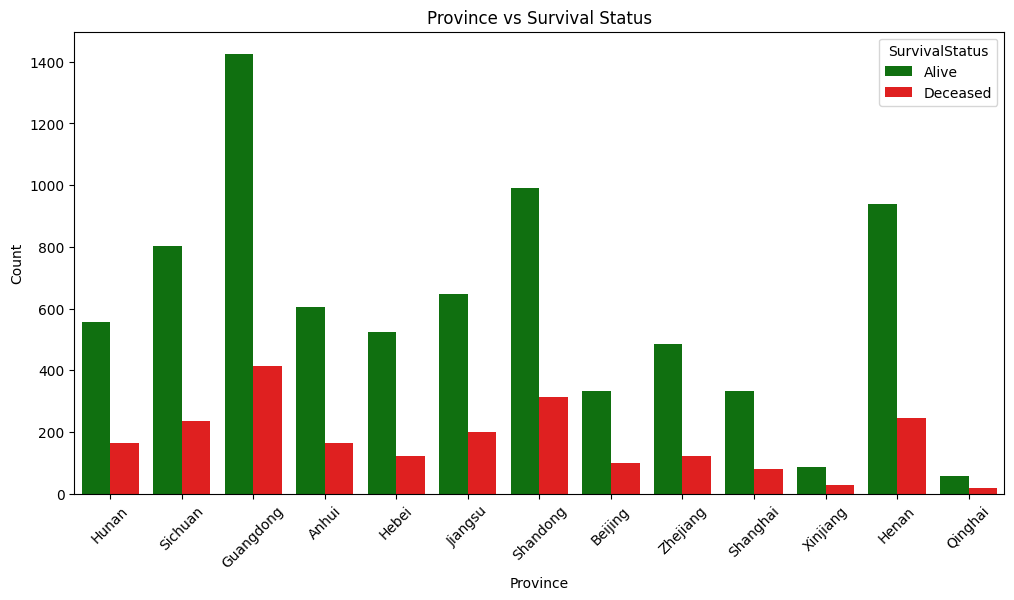

In [16]:
# Visualize the distribution of province vs survival status
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='Province', hue='SurvivalStatus', palette=color_palette)
plt.title('Province vs Survival Status')
plt.xlabel('Province')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [17]:
# Calculate the percentage of survival in each province
province_survival = df_clean.groupby('Province')['SurvivalStatus'].value_counts(normalize=True).unstack().fillna(0) * 100
province_survival.sort_values(ascending=False, by='Alive', inplace=True)
province_survival

SurvivalStatus,Alive,Deceased
Province,,
Hebei,81.018519,18.981481
Shanghai,80.871671,19.128329
Zhejiang,80.065898,19.934102
Henan,79.173693,20.826307
Anhui,78.543563,21.456437
Guangdong,77.457903,22.542097
Sichuan,77.263969,22.736031
Hunan,77.178423,22.821577
Beijing,76.851852,23.148148


Note: The survival rates vary accross provinces, but not significantly. The provinces with the highest survival rates are 'Hebei', 'Shanghai', and 'Zhejiang', while 'Xinjiang', 'Beijing', 'Hunan' have the lowest survival rates.
Because the difference is not significant, we will not drop any provinces from the dataset.

C:\Users\reyge\AppData\Local\Temp\ipykernel_21412\655478736.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.countplot(
C:\Users\reyge\AppData\Local\Temp\ipykernel_21412\655478736.py:15: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.countplot(


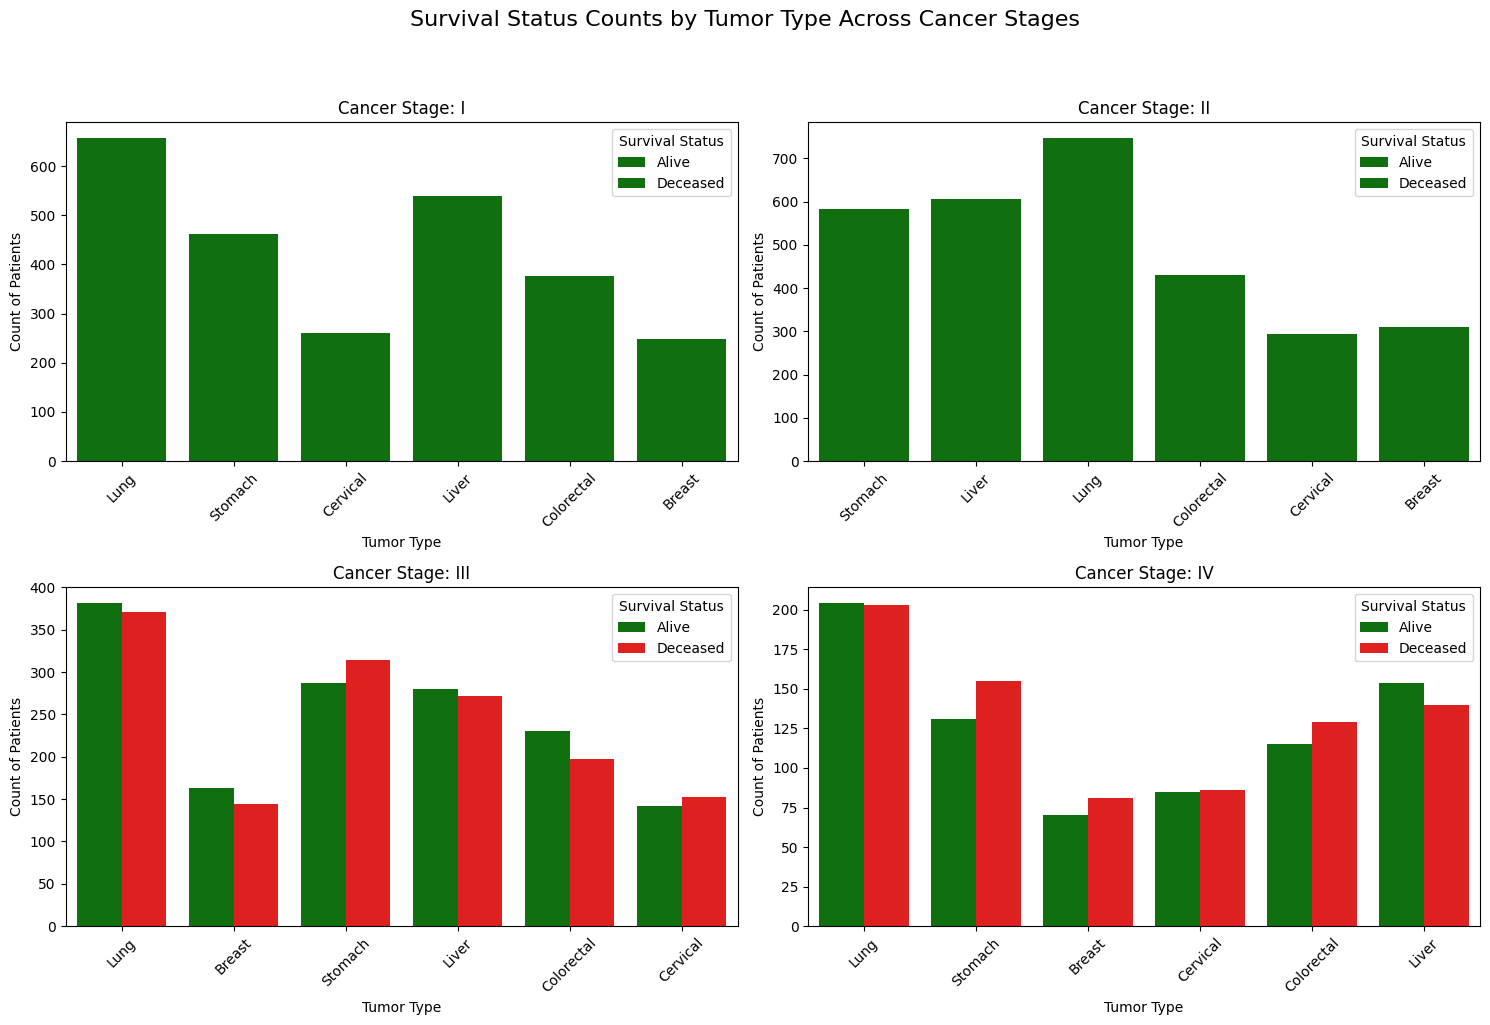

In [18]:
# Visualize the distribution of tumor type and cancer stage vs survival status

# TumorType and CancerStage are categorical variables, we will use a count plot to visualize the distribution of these variables against the survival status in one plot.

# Order the CancerStage categories
cancer_stage = ['I', 'II', 'III', 'IV']
df_clean['CancerStage'] = pd.Categorical(df_clean['CancerStage'], categories=cancer_stage, ordered=True)

# Create a categorical plot for TumorType and CancerStage
plt.figure(figsize=(15, 10)) # Overall figure size

for i, stage in enumerate(df_clean['CancerStage'].cat.categories):
    plt.subplot(2, 2, i + 1) # i+1 because subplot index starts at 1

    sns.countplot(
        data=df_clean[df_clean['CancerStage'] == stage],
        x='TumorType',
        hue='SurvivalStatus',
        palette=color_palette
    )

    plt.title(f'Cancer Stage: {stage}')
    plt.xlabel('Tumor Type')
    plt.ylabel('Count of Patients')
    plt.xticks(rotation=45)
    plt.legend(title='Survival Status', loc='upper right', labels=['Alive', 'Deceased'])

# Overall title for the entire figure
plt.suptitle('Survival Status Counts by Tumor Type Across Cancer Stages', y=1.02, fontsize=16)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout(rect=(0, 0, 1, 0.98)) # rect leaves space for suptitle

plt.show()

Note: The distribution of tumor types and cancer stages against survival status shows that certain tumor types and stages have a higher survival rate than others. For example, Stage I and Stage II have higher survival rates across most tumor types, while Stage III and Stage IV have significantly lower survival rates.

In [19]:
# # Visualize the distribution of distance between diagnosis and surgery date vs survival status

# # Calculate the difference in days between DiagnosisDate and SurgeryDate
# df_clean['DaysBetweenDiagnosisAndSurgery'] = (pd.to_datetime(df_clean['SurgeryDate']) - pd.to_datetime(df_clean['DiagnosisDate'])).dt.days

# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_clean, x='DaysBetweenDiagnosisAndSurgery', hue='SurvivalStatus', multiple='stack', kde=True, palette=color_palette)
# plt.title('Days Between Diagnosis and Surgery vs Survival Status')
# plt.xlabel('Days Between Diagnosis and Surgery')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.show()


Note: The peak is at about 100 days, because at first stage we imputed the missing values of SurgeryDate with the mean date of the differences between SurgeryDate and DiagnosisDate.

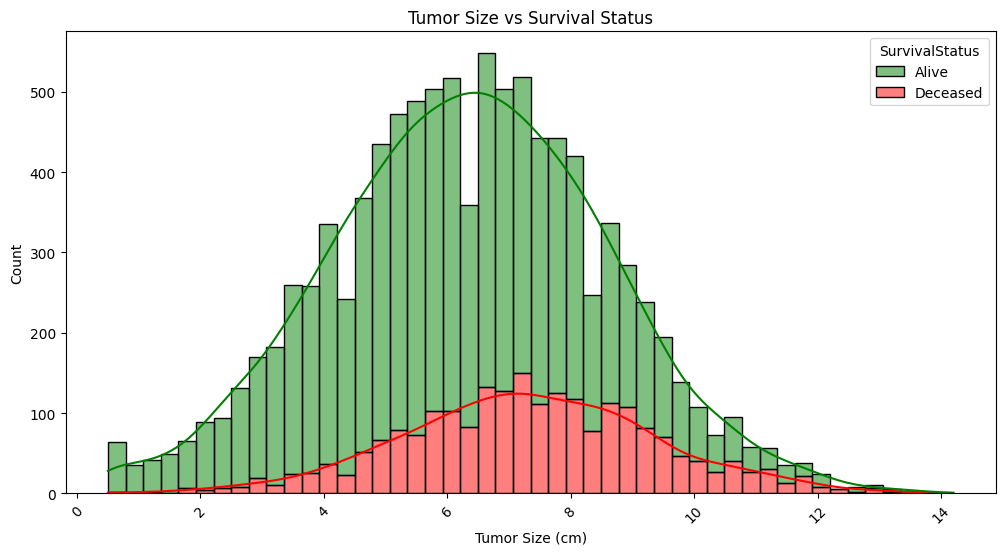

In [20]:
# Visualize the distribution of tumor size vs survival status
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='TumorSize', hue='SurvivalStatus', multiple='stack', kde=True, palette=color_palette)
plt.title('Tumor Size vs Survival Status')
plt.xlabel('Tumor Size (cm)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note: Higher tumor sizes are associated with lower survival rates, indicating that larger tumors may be more aggressive or harder to treat.

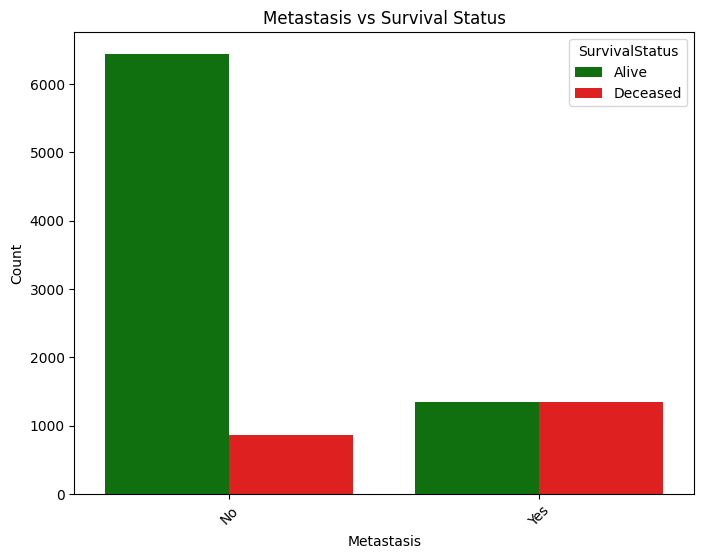

In [21]:
# Visualize the distribution of metastasis vs survival status
plt.figure(figsize=(8, 6))
sns.countplot(data=df_clean, x='Metastasis', hue='SurvivalStatus', palette=color_palette)
plt.title('Metastasis vs Survival Status')
plt.xlabel('Metastasis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note: The presence of metastasis is associated with lower survival rates, indicating that metastatic cancer is more difficult to treat and has a poorer prognosis.

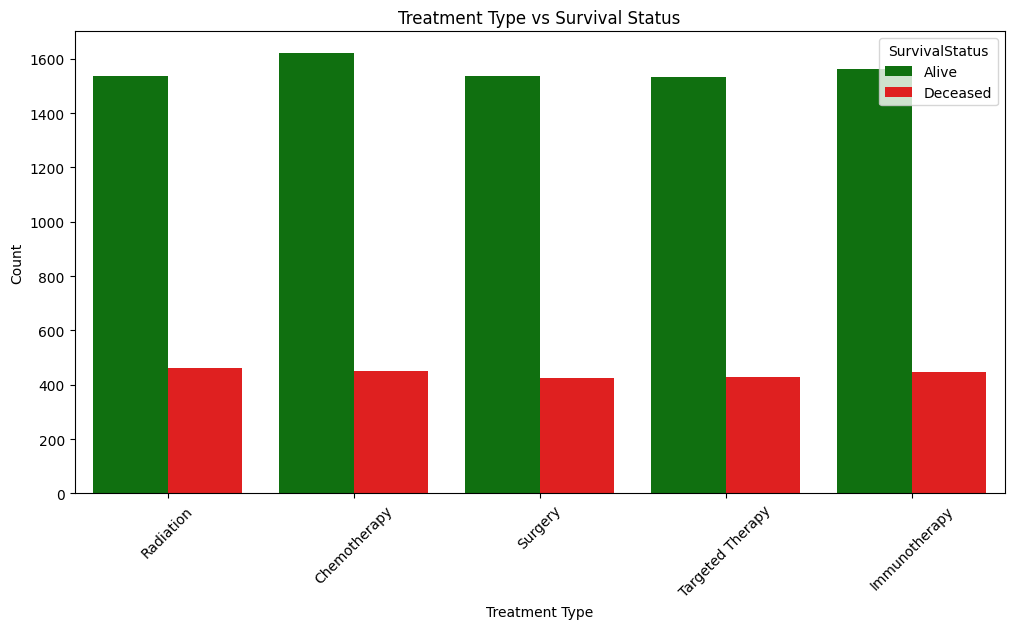

In [22]:
# Visualize the distribution of treatment type vs survival status
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='TreatmentType', hue='SurvivalStatus', palette=color_palette)
plt.title('Treatment Type vs Survival Status')
plt.xlabel('Treatment Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Calculate the percentage of survival each treatment type in the dataset
treatment_survival = df_clean.groupby('TreatmentType')['SurvivalStatus'].value_counts(normalize=True).unstack().fillna(0) * 100
treatment_survival.sort_values(ascending=False, inplace=True, by='Alive')
treatment_survival

SurvivalStatus,Alive,Deceased
TreatmentType,,
Surgery,78.418367,21.581633
Targeted Therapy,78.225395,21.774605
Chemotherapy,78.185328,21.814672
Immunotherapy,77.711443,22.288557
Radiation,76.965448,23.034552


Note: Different treatment types have similar survival rates, with surgery, targeted therapy, and chemotherapy showing slightly higher survival rates compared to other treatment types. This suggests that a combination of treatments may be more effective in improving survival outcomes.
Because the difference is not significant, we will not drop any treatment types from the dataset.

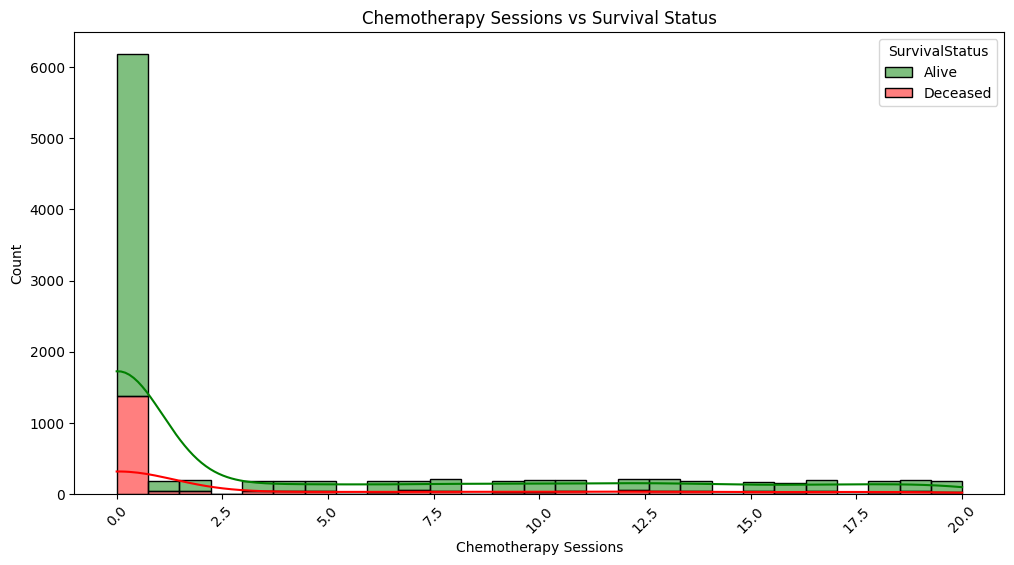

In [24]:
# Visualize the distribution of chemotherapy sessions vs survival status
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='ChemotherapySessions', hue='SurvivalStatus', multiple='stack', kde=True, palette=color_palette)
plt.title('Chemotherapy Sessions vs Survival Status')
plt.xlabel('Chemotherapy Sessions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Calculate the normalized chemotherapy sessions vs survival status
chemotherapy_sessions = df_clean.groupby('ChemotherapySessions')['SurvivalStatus'].value_counts(normalize=True).unstack() * 100
chemotherapy_sessions

SurvivalStatus,Alive,Deceased
ChemotherapySessions,,
0,77.790359,22.209641
1,79.473684,20.526316
2,79.901961,20.098039
3,73.655914,26.344086
4,79.569892,20.430108
5,77.717391,22.282609
6,79.888268,20.111732
7,70.879121,29.120879
8,80.281690,19.718310


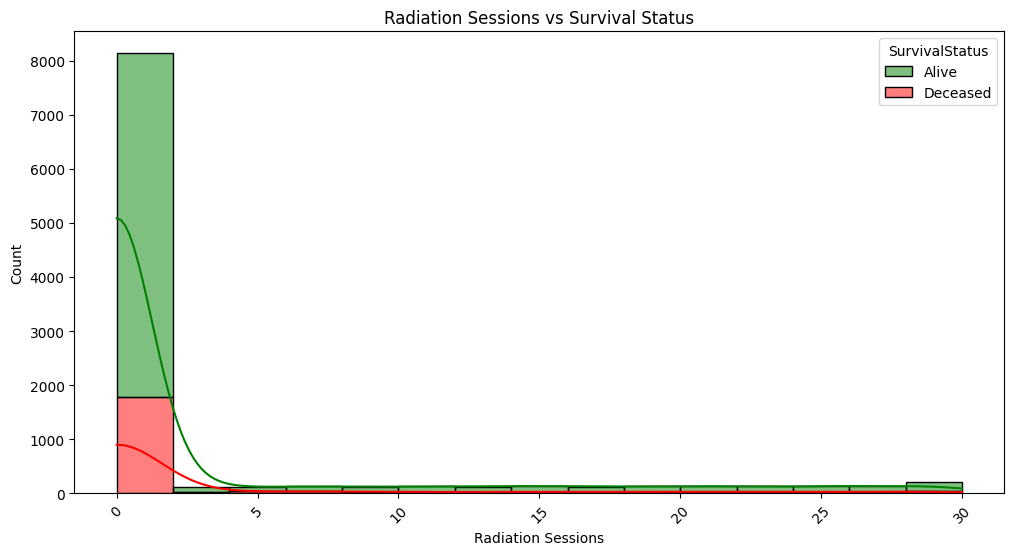

In [26]:
# Visualize the distribution of radiation sessions vs survival status
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='RadiationSessions', hue='SurvivalStatus', multiple='stack', kde=True, palette=color_palette)
plt.title('Radiation Sessions vs Survival Status')
plt.xlabel('Radiation Sessions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x600 with 0 Axes>

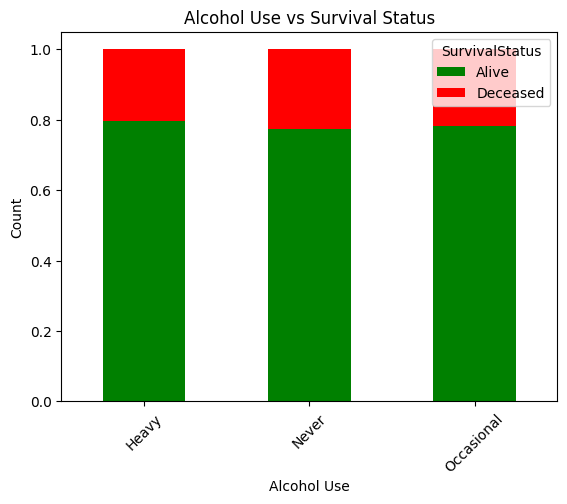

In [27]:
# Visualize the distribution of alcohol use vs survival status normalized
# Calculate the normalized counts for AlcoholUse and SurvivalStatus
alcohol_counts = df_clean.groupby(['AlcoholUse', 'SurvivalStatus']).size().unstack().fillna(0)
alcohol_counts_normalized = alcohol_counts.div(alcohol_counts.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(8, 6))
alcohol_counts_normalized.plot(kind='bar', stacked=True, color=color_palette)
plt.title('Alcohol Use vs Survival Status')
plt.xlabel('Alcohol Use')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note: Alcohol use does not show a significant difference in survival rates, indicating that alcohol consumption may not be a major factor affecting cancer survival in this dataset.

<Figure size 800x600 with 0 Axes>

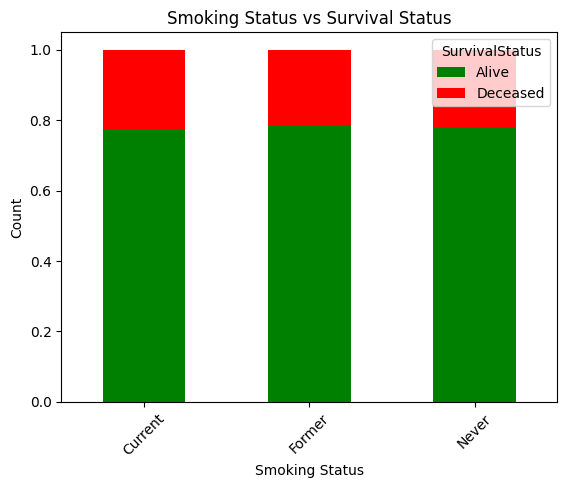

In [28]:
# Visualize the distribution of smoking status vs survival status normalized

# Calculate the normalized counts for SmokingStatus and SurvivalStatus
smoking_counts = df_clean.groupby(['SmokingStatus', 'SurvivalStatus']).size().unstack().fillna(0)
smoking_counts_normalized = smoking_counts.div(smoking_counts.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(8, 6))
smoking_counts_normalized.plot(kind='bar', stacked=True, color=color_palette)
plt.title('Smoking Status vs Survival Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note: Smoking status does not show a significant difference in survival rates, indicating that smoking may not be a major factor affecting cancer survival in this dataset. However, it is important to note that smoking is generally associated with a higher risk of developing cancer and other health issues.

<Figure size 800x600 with 0 Axes>

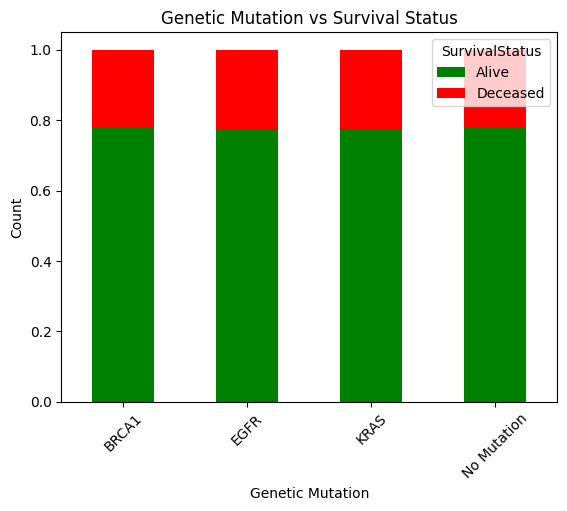

In [29]:
# Visualize the distribution of genetic mutation vs survival status normalized
# Calculate the normalized counts for GeneticMutation and SurvivalStatus
genetic_counts = df_clean.groupby(['GeneticMutation', 'SurvivalStatus']).size().unstack().fillna(0)
genetic_counts_normalized = genetic_counts.div(genetic_counts.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(8, 6))
genetic_counts_normalized.plot(kind='bar', stacked=True, color=color_palette)
plt.title('Genetic Mutation vs Survival Status')
plt.xlabel('Genetic Mutation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Note: Genetic mutation status does not show significant differences in survival rates, indicating that genetic mutations may not be a major factor affecting cancer survival in this dataset. However, it is important to note that certain genetic mutations can influence the response to treatment and overall prognosis in specific types of cancer.

<Figure size 800x600 with 0 Axes>

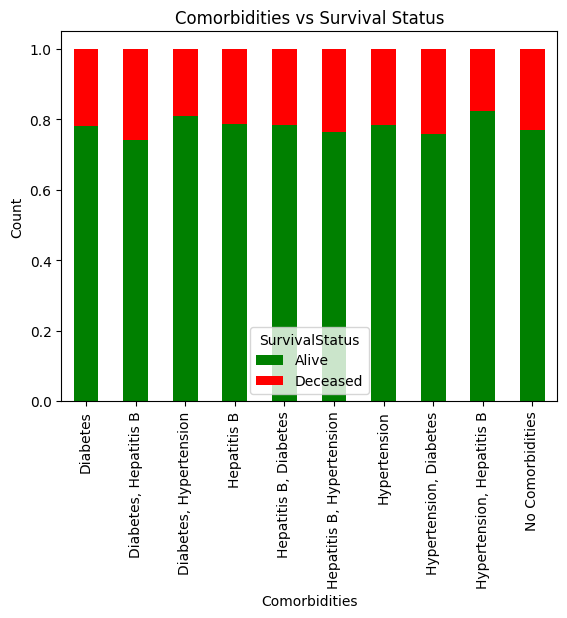

In [30]:
# Visualize the distribution of comorbidities vs survival status normalized
# Calculate the normalized counts for Comorbidities and SurvivalStatus
comorbidity_counts = df_clean.groupby(['Comorbidities', 'SurvivalStatus']).size().unstack().fillna(0)
comorbidity_counts_normalized = comorbidity_counts.div(comorbidity_counts.sum(axis=1), axis=0)

# Plot the normalized counts
plt.figure(figsize=(8, 6))
comorbidity_counts_normalized.plot(kind='bar', stacked=True, color=color_palette)
plt.title('Comorbidities vs Survival Status')
plt.xlabel('Comorbidities')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Note: Comorbidities shows some differences in survival rates, with patients having "Diabetes, Hepatitis B" comorbidities showing the lowest survival rates compared to those with other comorbidities. This suggests that the presence of comorbidities may negatively impact cancer survival outcomes.

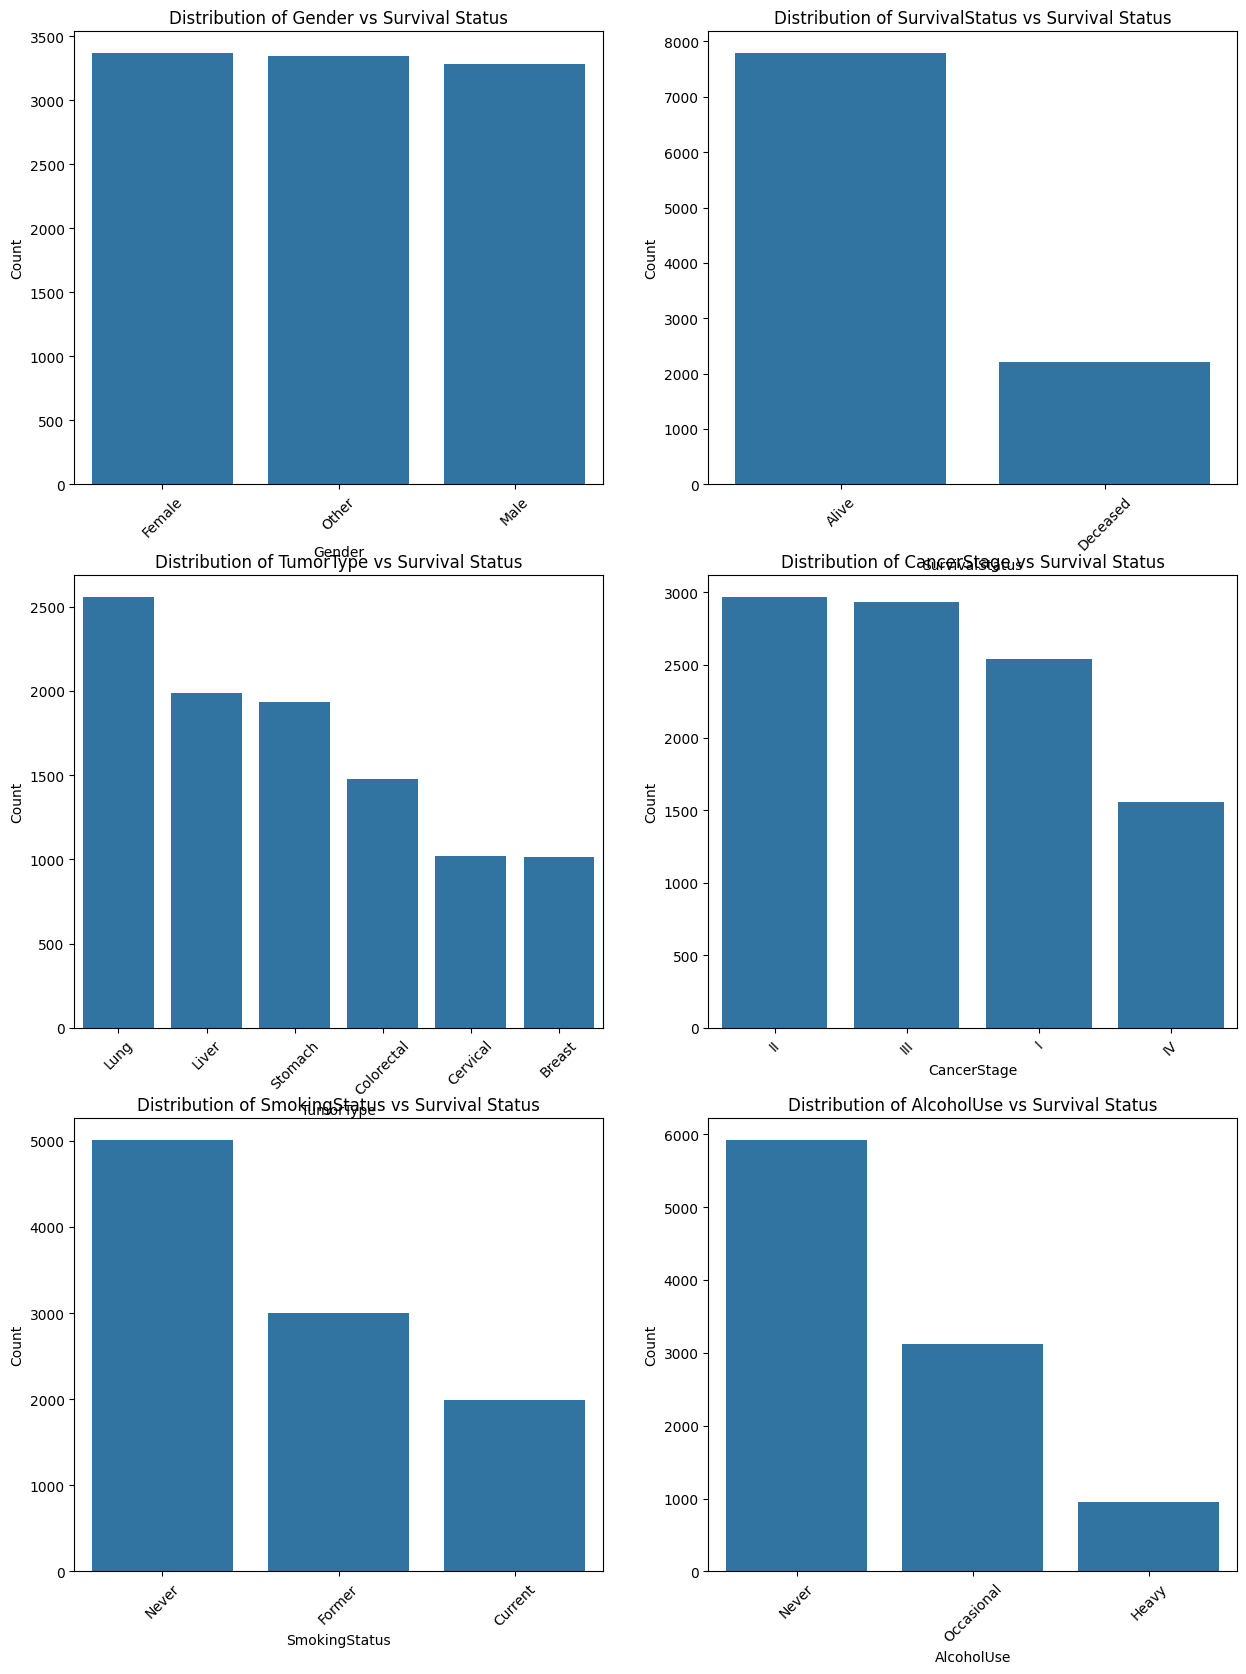

In [31]:
# Plot Distribution of Categorical Features
categorical_features = ['Gender', 'SurvivalStatus', 'TumorType', 'CancerStage', 'SmokingStatus', 'AlcoholUse']
plt.figure(figsize=(15, 20))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i + 1)
    sns.countplot(data=df_clean, x=feature, order=df_clean[feature].value_counts().index)
    plt.title(f'Distribution of {feature} vs Survival Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

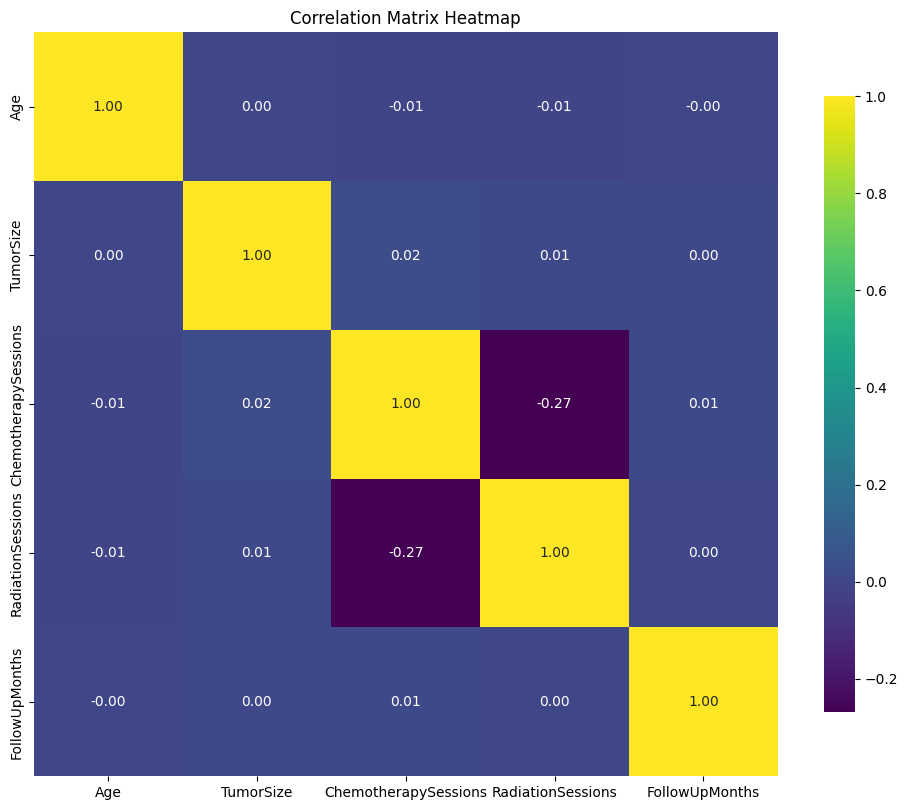

In [32]:
# Heatmap for Correlation Matrix
correlation_matrix = df_clean.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.show()

<Figure size 1200x1200 with 0 Axes>

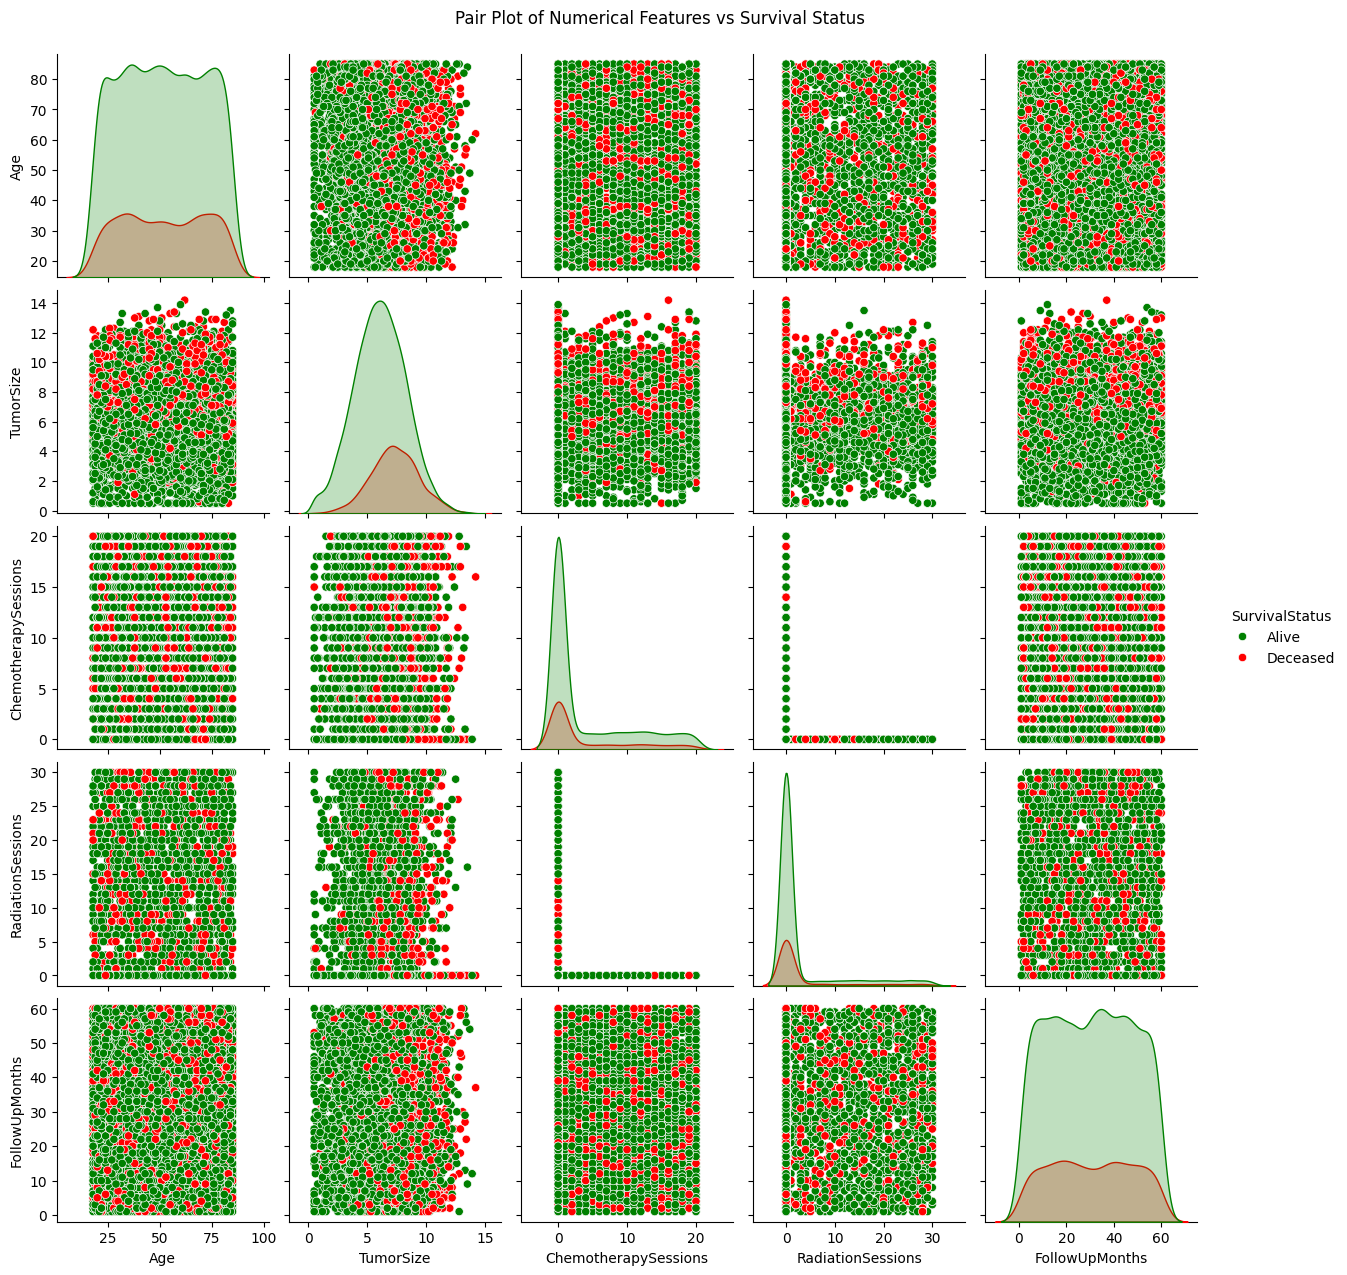

In [33]:
# Pair Plot for Numerical Features
plt.figure(figsize=(12, 12))
sns.pairplot(df_clean, hue='SurvivalStatus', vars=numerical_features, palette=color_palette)
plt.suptitle('Pair Plot of Numerical Features vs Survival Status', y=1.02)
plt.show()

# 4. Feature Selection

In [34]:
df_clean

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,Never,No Mutation,No Comorbidities
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,Never,No Mutation,No Comorbidities
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,No Comorbidities
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,2012-05-21,4,0,Alive,42,Never,Never,No Mutation,No Comorbidities
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CHN-09996,Female,21,Shandong,Han,Liver,IV,2018-07-11,8.5,Yes,Targeted Therapy,2018-11-14,12,0,Alive,57,Never,Occasional,KRAS,Hypertension
9996,CHN-09997,Female,35,Shanghai,Han,Cervical,II,2016-03-31,6.5,No,Targeted Therapy,2016-09-03,20,0,Alive,36,Never,Never,No Mutation,Hepatitis B
9997,CHN-09998,Female,58,Shandong,Han,Cervical,III,2019-09-03,8.0,Yes,Immunotherapy,2019-11-29,0,0,Alive,35,Former,Occasional,No Mutation,"Hepatitis B, Hypertension"
9998,CHN-09999,Male,26,Hebei,Han,Lung,I,2014-03-16,6.2,No,Chemotherapy,2014-06-28,2,0,Alive,25,Current,Occasional,KRAS,No Comorbidities


In [35]:
# Remove irrelevant features and features with high correlation
def select_features(df, features_to_drop):
    df_selected = df.copy();
    df_selected.drop(columns=features_to_drop, inplace=True)
    return df_selected

In [36]:
irrelevant_features = ['PatientID', 'Gender', 'Province', 'Ethnicity', 'DiagnosisDate', 'SurgeryDate']
high_correlated_features = ['RadiationSessions']

# Combine the features to drop
features_to_drop = irrelevant_features + high_correlated_features

# Select the relevant features
df_selected = select_features(df_clean, features_to_drop)

In [37]:
df_selected

,Age,TumorType,CancerStage,TumorSize,Metastasis,TreatmentType,ChemotherapySessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,32,Lung,I,8.2,No,Radiation,0,Alive,44,Current,Never,No Mutation,No Comorbidities
1,66,Lung,IV,9.5,Yes,Chemotherapy,11,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,26,Lung,III,9.3,Yes,Surgery,0,Alive,40,Former,Never,No Mutation,No Comorbidities
3,35,Breast,III,7.7,No,Surgery,0,Deceased,45,Never,Occasional,KRAS,No Comorbidities
4,32,Stomach,II,7.3,No,Chemotherapy,4,Alive,42,Never,Never,No Mutation,No Comorbidities
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21,Liver,IV,8.5,Yes,Targeted Therapy,12,Alive,57,Never,Occasional,KRAS,Hypertension
9996,35,Cervical,II,6.5,No,Targeted Therapy,20,Alive,36,Never,Never,No Mutation,Hepatitis B
9997,58,Cervical,III,8.0,Yes,Immunotherapy,0,Alive,35,Former,Occasional,No Mutation,"Hepatitis B, Hypertension"
9998,26,Lung,I,6.2,No,Chemotherapy,2,Alive,25,Current,Occasional,KRAS,No Comorbidities


# 5. Feature Encoding

In [ ]:
# Encode categorical variables using Label Encoding and One-Hot Encoding

# Ordinal Encoding for binary and ordinal categorical variables: Gender, CancerStage, Metastasis, AlcoholUse, SmokingStatus, SurvivalStatus
# One-Hot Encoding for nominal categorical variables: Province, TumorType, TreatmentType, GeneticMutation, Comorbidities

def encode_features(df):
    # Create a copy of the DataFrame to avoid modifying the original directly
    df_encoded = df.copy()

    # Define order for ordinal categorical variables
    ordinal_orders = {
        'CancerStage': ['I', 'II', 'III', 'IV'],
        'AlcoholUse': ['Never', 'Occasionally', 'Heavy'],
        'SmokingStatus': ['Never', 'Former', 'Current'],
        'Metastasis': ['No', 'Yes'],
        'SurvivalStatus': ['Alive', 'Deceased']
    }

    # 

    # Ordinal Encoding for ordinal categorical variables
    ordinal_cols = ['CancerStage', 'Metastasis', 'AlcoholUse', 'SmokingStatus', 'SurvivalStatus']
    ordinal_encoders = {}

    for col in ordinal_cols:
        oe = OrdinalEncoder(categories=[ordinal_orders[col]], dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1)
        df_encoded[col] = oe.fit_transform(df_encoded[[col]])
        ordinal_encoders[col] = oe

    #One-Hot Encoding for nominal categorical variables
    one_hot_cols = ['TumorType', 'TreatmentType', 'GeneticMutation', 'Comorbidities']
    one_hot_encoders = {}

    # Initialize a list to hold the DataFrames from One-Hot Encoding
    ohe_dfs = []

    for col in one_hot_cols:
        ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
        encoded_array = ohe.fit_transform(df_encoded[[col]])

        # Get feature names for the new columns
        feature_names = ohe.get_feature_names_out([col])

        # Create a DataFrame from the encoded array with meaningful column names
        encoded_df_part = pd.DataFrame(encoded_array, columns=feature_names, index=df_encoded.index)
        ohe_dfs.append(encoded_df_part)
        one_hot_encoders[col] = ohe # Store the fitted encoder

        # Drop the original categorical column from df_encoded after it's been one-hot encoded
        df_encoded = df_encoded.drop(columns=[col])

    # Concatenate the one-hot encoded DataFrames with the main encoded DataFrame
    if ohe_dfs: # Only concatenate if there are one-hot encoded columns
        df_encoded = pd.concat([df_encoded] + ohe_dfs, axis=1)

    return df_encoded, ordinal_encoders, one_hot_encoders

In [39]:
df_encoded, ordinal_encoders, one_hot_encoders = encode_features(df_selected)

In [40]:
# Check correlation with the target variable after encoding

correlation_with_target = df_encoded.corr()['SurvivalStatus'].sort_values(ascending=False).abs()

print("Correlation with SurvivalStatus after encoding:")
print(correlation_with_target)

Correlation with SurvivalStatus after encoding:
SurvivalStatus                             1.000000
CancerStage                                0.517367
Metastasis                                 0.406393
TumorSize                                  0.236010
Comorbidities_Diabetes, Hepatitis B        0.015731
Comorbidities_No Comorbidities             0.014457
Age                                        0.011736
TreatmentType_Radiation                    0.011251
TumorType_Stomach                          0.010868
TumorType_Cervical                         0.009658
Comorbidities_Hypertension, Diabetes       0.008503
FollowUpMonths                             0.007619
Comorbidities_Hepatitis B, Hypertension    0.006519
GeneticMutation_EGFR                       0.005597
TumorType_Lung                             0.004980
GeneticMutation_KRAS                       0.004055
SmokingStatus                              0.002326
TreatmentType_Immunotherapy                0.002279
Comorbidities_He

In [41]:
# Drop features with low correlation with the target variable
low_correlation_threshold = 0.01
features_to_drop = correlation_with_target[correlation_with_target < low_correlation_threshold].index.tolist()

# Drop the features with low correlation
df_drop = df_encoded.copy()
df_drop.drop(columns=features_to_drop, inplace=True)

In [42]:
df_drop

,Age,CancerStage,TumorSize,Metastasis,SurvivalStatus,TumorType_Stomach,TreatmentType_Radiation,"Comorbidities_Diabetes, Hepatitis B","Comorbidities_Diabetes, Hypertension","Comorbidities_Hypertension, Hepatitis B",Comorbidities_No Comorbidities
0,32,0,8.2,0,0,0.0,1.0,0.0,0.0,0.0,1.0
1,66,3,9.5,1,1,0.0,0.0,0.0,0.0,0.0,0.0
2,26,2,9.3,1,0,0.0,0.0,0.0,0.0,0.0,1.0
3,35,2,7.7,0,1,0.0,0.0,0.0,0.0,0.0,1.0
4,32,1,7.3,0,0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,21,3,8.5,1,0,0.0,0.0,0.0,0.0,0.0,0.0
9996,35,1,6.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0
9997,58,2,8.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
9998,26,0,6.2,0,0,0.0,0.0,0.0,0.0,0.0,1.0


# 6. Train-Test Split

In [43]:
# Split the dataset into features and target variable
X = df_drop.drop(columns=['SurvivalStatus'])
y = df_drop['SurvivalStatus']

# Split the dataset into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (8000, 10), Testing set shape: (2000, 10)


In [44]:
X_train

,Age,CancerStage,TumorSize,Metastasis,TumorType_Stomach,TreatmentType_Radiation,"Comorbidities_Diabetes, Hepatitis B","Comorbidities_Diabetes, Hypertension","Comorbidities_Hypertension, Hepatitis B",Comorbidities_No Comorbidities
7160,76,1,6.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3579,34,3,7.7,0,0.0,0.0,0.0,0.0,0.0,0.0
4833,57,2,3.9,1,1.0,1.0,0.0,0.0,0.0,1.0
729,42,2,4.5,1,1.0,0.0,0.0,0.0,0.0,0.0
8512,25,3,10.4,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4596,75,2,5.4,1,0.0,0.0,0.0,0.0,0.0,1.0
3482,31,1,7.3,0,0.0,0.0,0.0,0.0,0.0,1.0
346,71,2,9.4,1,0.0,0.0,0.0,0.0,0.0,0.0
4855,80,2,8.6,0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X_train.columns.to_list()

['Age',
 'CancerStage',
 'TumorSize',
 'Metastasis',
 'TumorType_Stomach',
 'TreatmentType_Radiation',
 'Comorbidities_Diabetes, Hepatitis B',
 'Comorbidities_Diabetes, Hypertension',
 'Comorbidities_Hypertension, Hepatitis B',
 'Comorbidities_No Comorbidities']

# 7. SMOTE

In [46]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"Resampled training set shape: {X_train.shape}, Resampled testing set shape: {X_test.shape}")

Resampled training set shape: (12464, 10), Resampled testing set shape: (2000, 10)


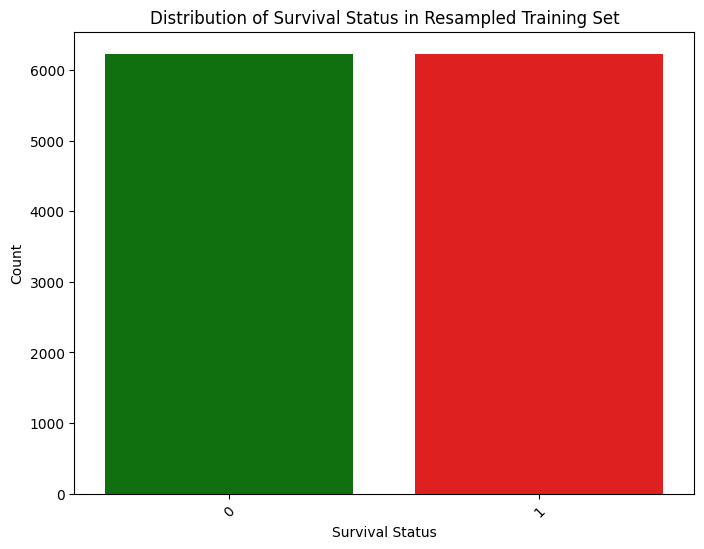

In [47]:
# Visualize the distribution of the target variable in the resampled training set
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette=color_palette)
plt.title('Distribution of Survival Status in Resampled Training Set')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 8. Feature Scaling

In [49]:
# Scale the numerical features excluding the target variable and the encoded categorical features
# features_to_scale = ['Age', 'TumorSize', 'ChemotherapySessions', 'FollowUpMonths', 'DaysBetweenDiagnosisAndSurgery']
features_to_scale = ['Age', 'TumorSize']
scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])
X_train_scaled = scaler.transform(X_train[features_to_scale])
X_test_scaled = scaler.transform(X_test[features_to_scale])

# Convert the scaled arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_to_scale, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_to_scale, index=X_test.index)

# Concatenate the scaled features with the encoded categorical features
X_train_scaled = pd.concat([X_train_scaled, X_train.drop(columns=features_to_scale)], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test.drop(columns=features_to_scale)], axis=1)

# Display the first few rows of the scaled training set
X_train_scaled.head()

,Age,TumorSize,CancerStage,Metastasis,TumorType_Stomach,TreatmentType_Radiation,"Comorbidities_Diabetes, Hepatitis B","Comorbidities_Diabetes, Hypertension","Comorbidities_Hypertension, Hepatitis B",Comorbidities_No Comorbidities
0,1.217582,-0.315001,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.911870,0.464009,3,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.254259,-1.277309,2,1,1.0,1.0,0.0,0.0,0.0,1.0
3,-0.506260,-1.002364,2,1,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.368181,1.701262,3,1,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_train_scaled.columns.to_list()

['Age',
 'TumorSize',
 'CancerStage',
 'Metastasis',
 'TumorType_Stomach',
 'TreatmentType_Radiation',
 'Comorbidities_Diabetes, Hepatitis B',
 'Comorbidities_Diabetes, Hypertension',
 'Comorbidities_Hypertension, Hepatitis B',
 'Comorbidities_No Comorbidities']

# 9. Model Training and Evaluation

## a. Logistic Regression

In [146]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [147]:
# Evaluate the model on the training set
y_pred_train_lr = lr_model.predict(X_train_scaled)
print("Logistic Regression Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_lr))

Logistic Regression Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      6232
           1       0.78      0.98      0.87      6232

    accuracy                           0.85     12464
   macro avg       0.88      0.85      0.85     12464
weighted avg       0.88      0.85      0.85     12464



In [148]:
# Predict on the test set
y_pred_lr = lr_model.predict(X_test_scaled)
# Evaluate the model
print("Logistic Regression Testing Set Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1558
           1       0.49      0.98      0.66       442

    accuracy                           0.77      2000
   macro avg       0.74      0.85      0.74      2000
weighted avg       0.88      0.77      0.79      2000



## b. K-Nearest Neighbors (KNN)

In [149]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [150]:
# Evaluate the model on the training set
y_pred_train_knn = knn_model.predict(X_train_scaled)
print("K-Nearest Neighbors Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_knn))

K-Nearest Neighbors Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      6232
           1       0.84      0.96      0.90      6232

    accuracy                           0.89     12464
   macro avg       0.90      0.89      0.89     12464
weighted avg       0.90      0.89      0.89     12464



In [151]:
# Evaluate the model on the test set
y_pred_knn = knn_model.predict(X_test_scaled)
print("K-Nearest Neighbors Testing Set Classification Report:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1558
           1       0.48      0.77      0.59       442

    accuracy                           0.76      2000
   macro avg       0.70      0.77      0.71      2000
weighted avg       0.82      0.76      0.78      2000



## c. Support Vector Machine (SVM)

In [152]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [153]:
# Evaluate the model on the training set
y_pred_train_svm = svm_model.predict(X_train_scaled)
print("Support Vector Machine Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_svm))

Support Vector Machine Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      6232
           1       0.77      1.00      0.87      6232

    accuracy                           0.85     12464
   macro avg       0.89      0.85      0.85     12464
weighted avg       0.89      0.85      0.85     12464



In [154]:
# Evaluate the model on the test set
y_pred_svm = svm_model.predict(X_test_scaled)
print("Support Vector Machine Testing Set Classification Report:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Testing Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      1558
           1       0.49      1.00      0.66       442

    accuracy                           0.77      2000
   macro avg       0.75      0.85      0.74      2000
weighted avg       0.89      0.77      0.79      2000



## d. Random Forest Classifier

In [155]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [156]:
# Evaluate the model on the training set
y_pred_train_rf = rf_model.predict(X_train_scaled)
print("Random Forest Classifier Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_rf))

Random Forest Classifier Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6232
           1       1.00      1.00      1.00      6232

    accuracy                           1.00     12464
   macro avg       1.00      1.00      1.00     12464
weighted avg       1.00      1.00      1.00     12464



In [157]:
# Evaluate the model on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classifier Testing Set Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1558
           1       0.49      0.57      0.53       442

    accuracy                           0.77      2000
   macro avg       0.68      0.70      0.69      2000
weighted avg       0.79      0.77      0.78      2000



## f. XGBoost Classifier

In [158]:
xgboost_model = XGBClassifier(random_state=42)
xgboost_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [159]:
# Evaluate the model on the training set
y_pred_train_xgb = xgboost_model.predict(X_train_scaled)
print("XGBoost Classifier Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_xgb))

XGBoost Classifier Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      6232
           1       0.88      0.98      0.93      6232

    accuracy                           0.92     12464
   macro avg       0.93      0.92      0.92     12464
weighted avg       0.93      0.92      0.92     12464



In [160]:
# Evaluate the model on the test set
y_pred_xgb = xgboost_model.predict(X_test_scaled)
print("XGBoost Classifier Testing Set Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1558
           1       0.49      0.70      0.57       442

    accuracy                           0.77      2000
   macro avg       0.69      0.75      0.71      2000
weighted avg       0.81      0.77      0.78      2000



Note: We could see that the models tend to overfit the training data, as the training set accuracy is significantly higher than the testing set accuracy. This is a common issue in machine learning, especially with complex models like Random Forest and XGBoost. We will need to tune the hyperparameters of these models to improve their generalization performance on the test set.

# 10. Hyperparameter Tuning

## a. Hyperparameter Tuning for Logistic Regression

In [161]:
lr = LogisticRegression(max_iter=1000, random_state=42)

param_grid_lr = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}
]

grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search_lr.fit(X_train_scaled, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_
print("Best Parameters for Logistic Regression:", best_params_lr)
print("Best Cross-Validation Score for Logistic Regression:", best_score_lr)

# Train the Logistic Regression model with the best parameters
lr_best = LogisticRegression(**best_params_lr, max_iter=1000, random_state=42)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score for Logistic Regression: 0.8726557440934283


In [162]:
# Evaluate the model on the training set
lr_best.fit(X_train_scaled, y_train)
y_pred_train_lr_best = lr_best.predict(X_train_scaled)
print("Logistic Regression Best Model Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_lr_best))

Logistic Regression Best Model Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      6232
           1       0.77      1.00      0.87      6232

    accuracy                           0.85     12464
   macro avg       0.89      0.85      0.85     12464
weighted avg       0.89      0.85      0.85     12464



In [163]:
# Evaluate the model on the testing set
y_pred_lr_best = lr_best.predict(X_test_scaled)
print("Logistic Regression Best Model Testing Set Classification Report:")
print(classification_report(y_test, y_pred_lr_best))


Logistic Regression Best Model Testing Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      1558
           1       0.49      1.00      0.66       442

    accuracy                           0.77      2000
   macro avg       0.75      0.85      0.74      2000
weighted avg       0.89      0.77      0.79      2000



## b. Hyperparameter Tuning for KNN

In [164]:
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search_knn.fit(X_train_scaled, y_train)

best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_
print("Best Parameters for K-Nearest Neighbors:", best_params_knn)
print("Best Cross-Validation Score for K-Nearest Neighbors:", best_score_knn)

# Train the K-Nearest Neighbors model with the best parameters
knn_best = KNeighborsClassifier(**best_params_knn)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best Cross-Validation Score for K-Nearest Neighbors: 0.8733526387511791


In [165]:
# Evaluate the model on the training set
knn_best.fit(X_train_scaled, y_train)
y_pred_train_knn_best = knn_best.predict(X_train_scaled)
print("Logistic Regression Best Model Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_knn_best))

Logistic Regression Best Model Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6232
           1       1.00      1.00      1.00      6232

    accuracy                           1.00     12464
   macro avg       1.00      1.00      1.00     12464
weighted avg       1.00      1.00      1.00     12464



In [166]:
# Evaluate the model on the testing set
y_pred_knn_best = knn_best.predict(X_test_scaled)
print("Logistic Regression Best Model Testing Set Classification Report:")
print(classification_report(y_test, y_pred_knn_best))

Logistic Regression Best Model Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1558
           1       0.49      0.78      0.60       442

    accuracy                           0.77      2000
   macro avg       0.71      0.77      0.72      2000
weighted avg       0.83      0.77      0.79      2000



## c. Hyperparameter Tuning for SVM

In [167]:
# svm = SVC()

# param_grid_svm = {
#     'C': [1, 2, 5, 10, 30, 50],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto']
# }

# grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2, scoring='f1')
# grid_search_svm.fit(X_train_scaled, y_train)

# best_params_svm = grid_search_svm.best_params_
# best_score_svm = grid_search_svm.best_score_
# print("Best Parameters for Support Vector Machine:", best_params_svm)
# print("Best Cross-Validation Score for Support Vector Machine:", best_score_svm)

# # Train the Support Vector Machine model with the best parameters
# svm_best = SVC(**best_params_svm)

In [168]:
# # Evaluate the model on the training set
# svm_best.fit(X_train_scaled, y_train)
# y_pred_train_svm_best = svm_best.predict(X_train_scaled)
# print("Logistic Regression Best Model Training Set Classification Report:")
# print(classification_report(y_train, y_pred_train_svm_best))

In [169]:
# # Evaluate the model on the testing set
# y_pred_svm_best = svm_best.predict(X_test_scaled)
# print("Logistic Regression Best Model Testing Set Classification Report:")
# print(classification_report(y_test, y_pred_svm_best))

## d. Hyperparameter Tuning for Random Forest Classifier

In [170]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search_rf.fit(X_train_scaled, y_train)

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best Parameters for Random Forest Classifier:", best_params_rf)
print("Best Cross-Validation Score for Random Forest Classifier:", best_score_rf)

# Train the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest Classifier: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score for Random Forest Classifier: 0.8647898960516878


In [171]:
# Evaluate the model on the training set
rf_best.fit(X_train_scaled, y_train)
y_pred_train_rf_best = rf_best.predict(X_train_scaled)
print("Random Forest Classifier (Best Parameters) Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_rf_best))

Random Forest Classifier (Best Parameters) Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      6232
           1       0.93      1.00      0.96      6232

    accuracy                           0.96     12464
   macro avg       0.96      0.96      0.96     12464
weighted avg       0.96      0.96      0.96     12464



In [172]:
# Evaluate the model on the test set
y_pred_rf_best = rf_best.predict(X_test_scaled)
print("Random Forest Classifier (Best Parameters) Testing Set Classification Report:")
print(classification_report(y_test, y_pred_rf_best))

Random Forest Classifier (Best Parameters) Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1558
           1       0.48      0.66      0.56       442

    accuracy                           0.77      2000
   macro avg       0.69      0.73      0.70      2000
weighted avg       0.80      0.77      0.78      2000



## e. Hyperparameter Tuning for XGBoost Classifier

In [173]:
xgboost = XGBClassifier(random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search_xgb.fit(X_train_scaled, y_train)

best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_
print("Best Parameters for XGBoost Classifier:", best_params_xgb)
print("Best Cross-Validation Score for XGBoost Classifier:", best_score_xgb)

# Train the XGBoost Classifier with the best parameters
xgb_best = XGBClassifier(**best_params_xgb, random_state=42)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters for XGBoost Classifier: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-Validation Score for XGBoost Classifier: 0.8709239161063416


In [174]:
# Evaluate the model on the training set
xgb_best.fit(X_train_scaled, y_train)
y_pred_train_xgb_best = xgb_best.predict(X_train_scaled)
print("XGBoost Classifier (Best Parameters) Training Set Classification Report:")
print(classification_report(y_train, y_pred_train_xgb_best))

XGBoost Classifier (Best Parameters) Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      6232
           1       0.78      1.00      0.87      6232

    accuracy                           0.86     12464
   macro avg       0.89      0.86      0.85     12464
weighted avg       0.89      0.86      0.85     12464



In [175]:
# Evaluate the model on the testing set
y_pred_xgb_best = xgb_best.predict(X_test_scaled)
print("XGBoost Classifier (Best Parameters) Testing Set Classification Report:")
print(classification_report(y_test, y_pred_xgb_best))

XGBoost Classifier (Best Parameters) Testing Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      1558
           1       0.49      0.99      0.66       442

    accuracy                           0.77      2000
   macro avg       0.74      0.85      0.74      2000
weighted avg       0.89      0.77      0.79      2000



# 11. Evaluating Model

Model Performance Before Hyperparameter Tuning:
     Accuracy  F1 Score  Precision  Recall
LR      0.773  0.792008   0.881056   0.773
KNN     0.764  0.780479   0.824282   0.764
SVC     0.771  0.790347   0.887536   0.771
RF      0.773  0.779289   0.787996   0.773
XGB     0.770  0.783241   0.811356   0.770


<Figure size 1200x800 with 0 Axes>

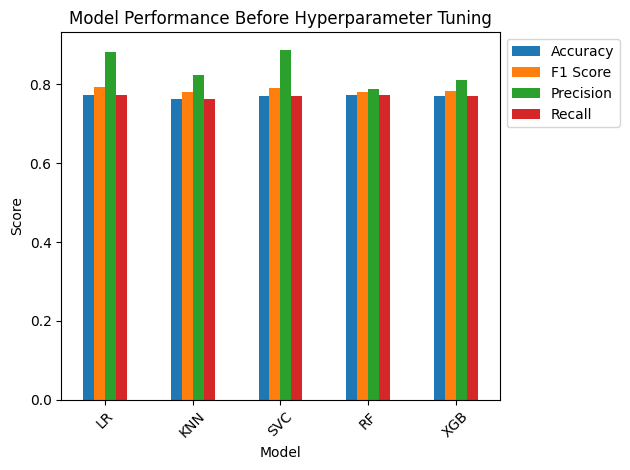

Model Performance After Hyperparameter Tuning:
     Accuracy  F1 Score  Precision  Recall
LR     0.7710  0.790347   0.887536  0.7710
KNN    0.7695  0.785499   0.828530  0.7695
RF     0.7680  0.779812   0.802117  0.7680
XGB    0.7730  0.792102   0.885205  0.7730


<Figure size 1200x800 with 0 Axes>

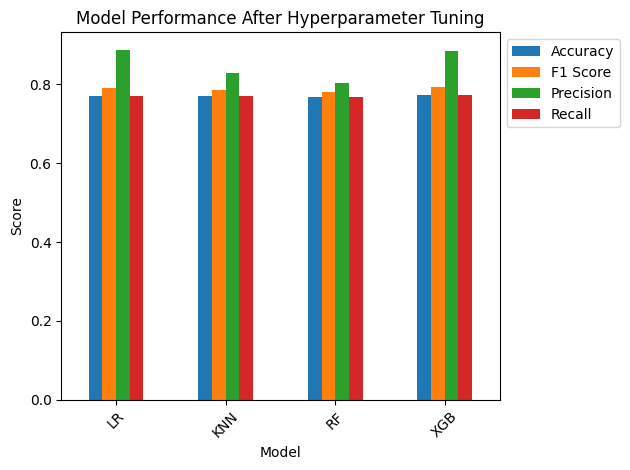

In [176]:
# Find the best model by comparing each model before and after hyperparameter tuning
models_before = {
    'LR': lr_model,
    'KNN': knn_model,
    'SVC': svm_model,
    'RF': rf_model,
    'XGB': xgboost_model
}

models_after = {
    'LR': lr_best,
    'KNN': knn_best,
    # 'SVC': svm_best,
    'RF': rf_best,
    'XGB': xgb_best
}

# Evaluate each model before hyperparameter tuning
results_before = {}
for model_name, model in models_before.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    results_before[model_name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

# Evaluate each model after hyperparameter tuning
results_after = {}
for model_name, model in models_after.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    results_after[model_name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

results_before_df = pd.DataFrame(results_before).T
results_after_df = pd.DataFrame(results_after).T

# Output the results before and after hyperparameter tuning
print("Model Performance Before Hyperparameter Tuning:")
print(pd.DataFrame(results_before).T)
plt.figure(figsize=(12, 8))

results_before_df[['Accuracy', 'F1 Score', 'Precision', 'Recall']].plot(kind='bar', rot=45)
plt.title('Model Performance Before Hyperparameter Tuning')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

print("Model Performance After Hyperparameter Tuning:")
print(pd.DataFrame(results_after).T)
plt.figure(figsize=(12, 8))
results_after_df[['Accuracy', 'F1 Score', 'Precision', 'Recall']].plot(kind='bar', rot=45)
plt.title('Model Performance After Hyperparameter Tuning')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Consideration:
The evualuation of XGBoost after Hyperparameter Tuning shows the best score so far, so we choose the XGBoost model after hyperparameter tuning to be our predictive model.

In [178]:
# Model Performance Before Hyperparameter Tuning:
#      Accuracy  F1 Score  Precision  Recall
# LR      0.773  0.792008   0.881056   0.773
# KNN     0.764  0.780479   0.824282   0.764
# SVC     0.771  0.790347   0.887536   0.771
# RF      0.773  0.779289   0.787996   0.773
# XGB     0.770  0.783241   0.811356   0.770

In [180]:
# Model Performance After Hyperparameter Tuning:
#      Accuracy  F1 Score  Precision  Recall
# LR     0.7710  0.790347   0.887536  0.7710
# KNN    0.7695  0.785499   0.828530  0.7695
# RF     0.7680  0.779812   0.802117  0.7680
# XGB    0.7730  0.792102   0.885205  0.7730

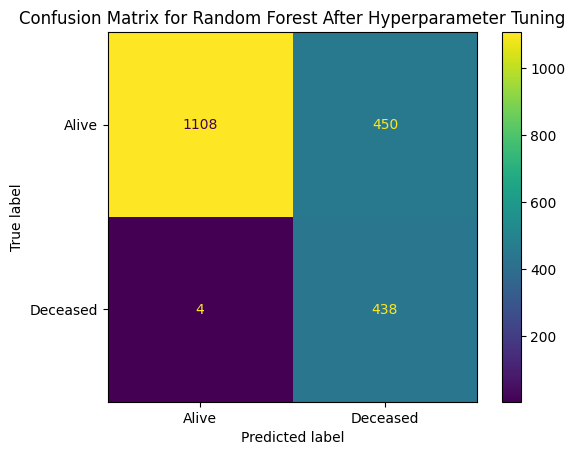

In [181]:
# Confusion Matrix for the Best Model
best_model = xgb_best
y_pred_best = best_model.predict(X_test_scaled)
ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, cmap='viridis', display_labels=['Alive', 'Deceased'])
plt.title('Confusion Matrix for Random Forest After Hyperparameter Tuning')
plt.show()


In [182]:
probabilities = xgb_best.predict_proba(X_test_scaled)
probabilities

array([[0.4578961 , 0.5421039 ],
       [0.42078018, 0.5792198 ],
       [0.68838143, 0.31161854],
       ...,
       [0.68838143, 0.31161854],
       [0.6572199 , 0.3427801 ],
       [0.6572199 , 0.3427801 ]], shape=(2000, 2), dtype=float32)

In [183]:
xgb_best.predict(X_test_scaled)

array([1, 1, 0, ..., 0, 0, 0], shape=(2000,))

# 12. Export the model using Pickle

In [184]:
import pickle

# Save the best model and encoders to disk
with open('models/XGB_cancer.pkl', 'wb') as model_file:
    pickle.dump(xgb_best, model_file)
with open('models/ordinal_encoders.pkl', 'wb') as le_file:
    pickle.dump(ordinal_encoders, le_file)
with open('models/one_hot_encoders.pkl', 'wb') as ohe_file:
    pickle.dump(one_hot_encoders, ohe_file)
with open('models/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [185]:
# Save the processed DataFrame to a CSV file
df_drop.to_csv('dataset/processed/processed_cancer_data.csv', index=False)

# Save the training and testing sets to CSV files
X_train_scaled.to_csv('dataset/processed/X_train_scaled.csv', index=False)
y_train.to_csv('dataset/processed/y_train.csv', index=False)
X_test_scaled.to_csv('dataset/processed/X_test_scaled.csv', index=False)
y_test.to_csv('dataset/processed/y_test.csv', index=False)

# Save the results DataFrames to CSV files
results_before_df.to_csv('dataset/processed/model_performance_before.csv')
results_after_df.to_csv('dataset/processed/model_performance_after.csv')

# 13. Test Load Model

In [186]:
import pickle
with open('models/XGB_cancer.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

loaded_probs = loaded_model.predict_proba(X_test_scaled)
# (loaded_probs == probabilities).all()

In [187]:
y_pred_best = loaded_model.predict(X_test_scaled)

In [188]:
probability = loaded_model.predict_proba(X_test_scaled)[:, 1]

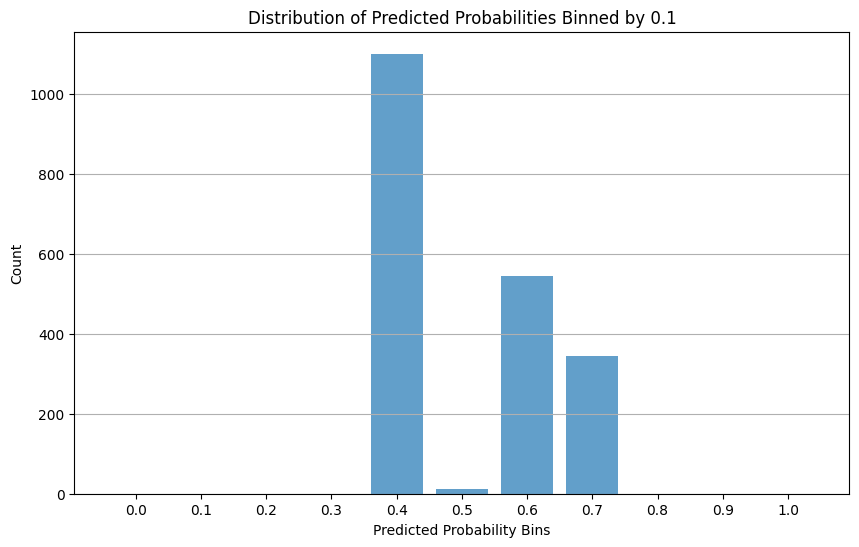

In [189]:
# Check the shape of the probabilities binned by 0.1
probability_binned = np.digitize(probability, bins=np.arange(0, 1.1, 0.1))

# Show the counts of each bin
bin_counts = np.bincount(probability_binned, minlength=11)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(0, 1.1, 0.1), bin_counts, width=0.08, align='center', alpha=0.7)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.title('Distribution of Predicted Probabilities Binned by 0.1')
plt.xlabel('Predicted Probability Bins')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

Predicted probabilities for patients predicted to be deceased but actually survived:
[0.5792198  0.56750274 0.57454467 0.6059858  0.5623583  0.59988403
 0.6059858  0.577139   0.5623583  0.5623583  0.5670545  0.6105497
 0.50856847 0.5949049  0.5598928  0.57745254 0.5949049  0.5827826
 0.6059858  0.5968538  0.6069456  0.6105497  0.5961219  0.602367
 0.589658   0.5949049  0.577139   0.6105497  0.5968538  0.5850932
 0.5792198  0.59652317 0.5949049  0.6105497  0.5968538  0.6069456
 0.5888566  0.5851938  0.6069456  0.5696823  0.6059858  0.6069456
 0.5922366  0.5826723  0.6059858  0.6105497  0.6105497  0.5961219
 0.5610165  0.5479723  0.55040514 0.50856847 0.59687686 0.6105497
 0.6105497  0.5962464  0.59282094 0.6069456  0.6105497  0.5850932
 0.60112447 0.5849014  0.6105497  0.5565378  0.6105497  0.60072476
 0.5610165  0.589658   0.5869977  0.5764684  0.57245785 0.6059858
 0.6059858  0.59885067 0.60112447 0.5922366  0.57245785 0.5623583
 0.5850932  0.6105497  0.6069456  0.577139   0.59282094 

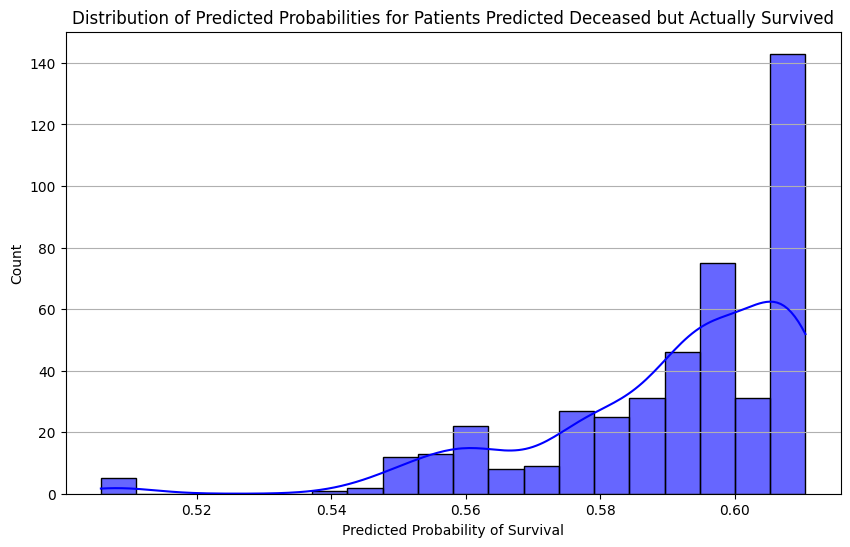

In [190]:
# Check the probability of the model predicting a patient will decease but actually survived
predicted_deceased_but_alive = X_test_scaled[(y_pred_best == 1) & (y_test == 0)]
predicted_deceased_but_alive_probabilities = loaded_model.predict_proba(predicted_deceased_but_alive)[:, 1]

# Show the predicted probabilities for patients predicted to be deceased but actually survived
print("Predicted probabilities for patients predicted to be deceased but actually survived:")
print(predicted_deceased_but_alive_probabilities)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(predicted_deceased_but_alive_probabilities, bins=20, kde=True, color='blue', alpha=0.6)
plt.title('Distribution of Predicted Probabilities for Patients Predicted Deceased but Actually Survived')
plt.xlabel('Predicted Probability of Survival')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

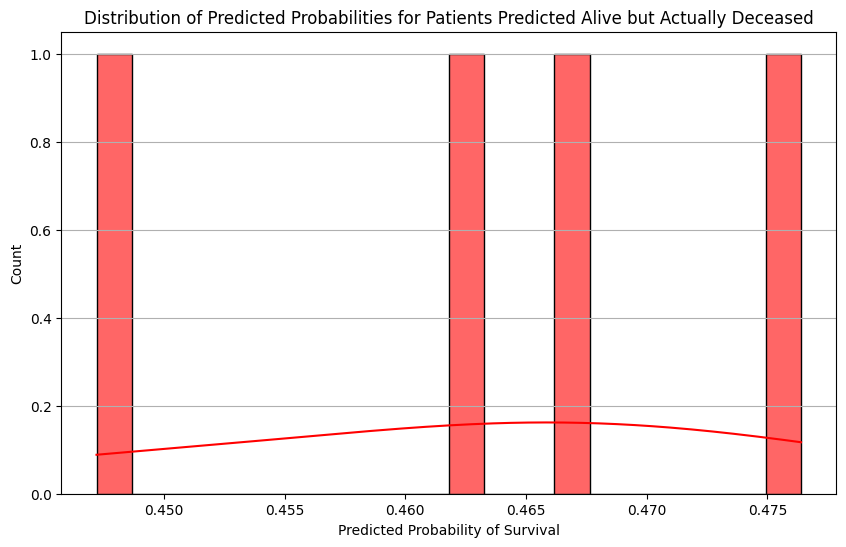

In [191]:
# Check the probability of the model predicting a patient will survive but actually deceased
predicted_alive_but_deceased = X_test_scaled[(y_pred_best == 0) & (y_test == 1)]
predicted_alive_but_deceased_probabilities = loaded_model.predict_proba(predicted_alive_but_deceased)[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(predicted_alive_but_deceased_probabilities, bins=20, kde=True, color='red', alpha=0.6)
plt.title('Distribution of Predicted Probabilities for Patients Predicted Alive but Actually Deceased')
plt.xlabel('Predicted Probability of Survival')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

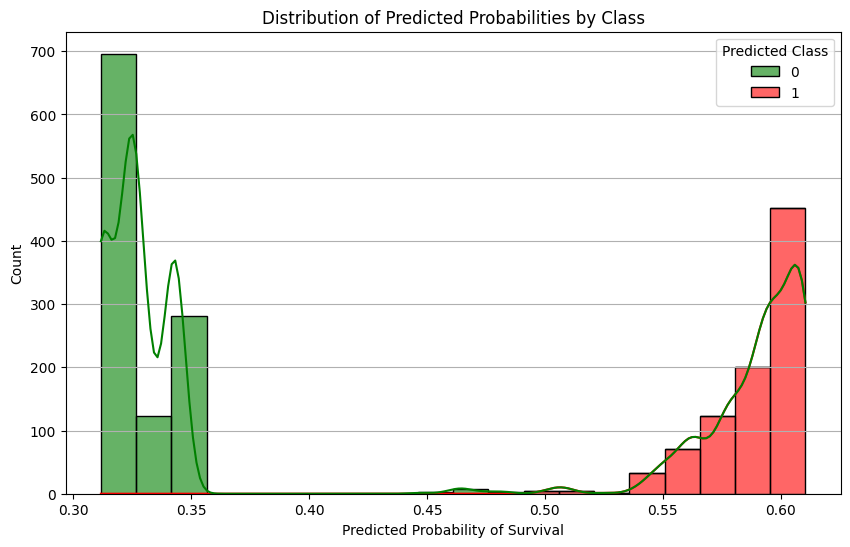

In [192]:
# Show probability distribution of each category (survived and deceased) for all patients
probability_and_class = pd.DataFrame({
    'Probability': probability,
    'Predicted Class': y_pred_best
})

plt.figure(figsize=(10, 6))
sns.histplot(data=probability_and_class, x='Probability', hue='Predicted Class', multiple='stack', bins=20, kde=True, palette=color_palette, alpha=0.6)
plt.title('Distribution of Predicted Probabilities by Class')
plt.xlabel('Predicted Probability of Survival')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


In [194]:
with open('models/ordinal_encoders.pkl', 'rb') as le_file:
    loaded_label_encoders = pickle.load(le_file)

loaded_label_encoders

{'CancerStage': OrdinalEncoder(categories=[['I', 'II', 'III', 'IV']],
                dtype=<class 'numpy.int64'>, handle_unknown='use_encoded_value',
                unknown_value=-1),
 'Metastasis': OrdinalEncoder(categories=[['No', 'Yes']], dtype=<class 'numpy.int64'>,
                handle_unknown='use_encoded_value', unknown_value=-1),
 'AlcoholUse': OrdinalEncoder(categories=[['Never', 'Occasionally', 'Heavy']],
                dtype=<class 'numpy.int64'>, handle_unknown='use_encoded_value',
                unknown_value=-1),
 'SmokingStatus': OrdinalEncoder(categories=[['Never', 'Former', 'Current']],
                dtype=<class 'numpy.int64'>, handle_unknown='use_encoded_value',
                unknown_value=-1),
 'SurvivalStatus': OrdinalEncoder(categories=[['Alive', 'Deceased']], dtype=<class 'numpy.int64'>,
                handle_unknown='use_encoded_value', unknown_value=-1)}